# Round #1: Simple Model

Set up environment

In [ ]:
pip install transformers pandas

Importing required libraries

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import torch
import pandas as pd

Load FinBERT Model and Tokenizer

In [ ]:
# FinBERT is a BERT model pre-trained on financial texts, loaded from Huggingface
model_name = "yiyanghkust/finbert-tone"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Data Preparation - sample texts

In [ ]:
sample_texts = [
    "The company’s revenue has exceeded the forecasts for this quarter.",
    "There are concerns about potential losses due to the ongoing litigation.",
    "Investors are optimistic about the new product launch.",
    "The market is facing uncertainty due to geopolitical tensions."
]

Function to perform sentiment analysis on given text

In [ ]:
def sentiment_analysis(texts, model, tokenizer):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    predictions = torch.nn.functional.softmax(logits, dim=-1)
    return predictions

Run the sentiment analysis function on data

In [ ]:
results = sentiment_analysis(sample_texts, model, tokenizer)

Display results

In [ ]:
labels = ['Neutral', 'Positive', 'Negative']

# Convert predictions to dataframe for better visualization
df_results = pd.DataFrame(results.numpy(), columns=labels)
df_results['Text'] = sample_texts
df_results = df_results[['Text'] + labels]

print(df_results)

                                                Text       Neutral  Positive  \
0  The company’s revenue has exceeded the forecas...  1.923323e-08  1.000000   
1  There are concerns about potential losses due ...  1.300325e-06  0.000001   
2  Investors are optimistic about the new product...  1.864881e-08  1.000000   
3  The market is facing uncertainty due to geopol...  2.987178e-02  0.000002   

       Negative  
0  1.401783e-07  
1  9.999973e-01  
2  1.074326e-08  
3  9.701263e-01  


Save results

In [ ]:
df_results.to_csv('sentiment_analysis_results.csv', index=False)

# Round 2: More Complex Model

Set up environment

In [ ]:
pip install transformers datasets

Code for FinBert model on 'financial_phrasebank' dataset

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
import torch
import pandas as pd
from datasets import DatasetDict

# Load the FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the financial_phrasebank dataset from Hugging Face
dataset = load_dataset("financial_phrasebank", 'sentences_allagree')

# Perform a split to create a new test set
train_val_split = dataset['train'].train_test_split(test_size=0.2)  # Reserve 20% for validation+test
test_split = train_val_split['test'].train_test_split(test_size=0.5)  # Split the 20% into 10% test and 10% validation

# Now we have a new training, validation, and test set
dataset = DatasetDict({
    'train': train_val_split['train'],
    'validation': test_split['train'],
    'test': test_split['test']
})

# Preprocess the dataset: tokenize and encode the sentences
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

encoded_dataset = dataset.map(tokenize_function, batched=True)

# Define the sentiment analysis function
def sentiment_analysis(predictions):
    labels = ['negative', 'neutral', 'positive']
    # Convert logits to probabilities
    probs = torch.nn.functional.softmax(predictions, dim=-1)
    # Get the highest probability label
    winner = labels[probs.argmax()]
    return winner

# Running sentiment analysis on the validation dataset
def run_sentiment_analysis(encoded_dataset):
    predictions = []
    for i in range(len(encoded_dataset)):
        with torch.no_grad():
            input_ids = torch.tensor(encoded_dataset[i]['input_ids']).unsqueeze(0)  # Batch size 1
            attention_mask = torch.tensor(encoded_dataset[i]['attention_mask']).unsqueeze(0)  # Batch size 1
            outputs = model(input_ids, attention_mask=attention_mask)
            prediction = sentiment_analysis(outputs.logits.squeeze(0))
            predictions.append(prediction)
    return predictions

# Run the analysis
predictions = run_sentiment_analysis(encoded_dataset['validation'])

# Combine the predictions with the original dataset
df = pd.DataFrame(dataset['validation'])
df['predicted_sentiment'] = predictions

print(df.head())

# Save the results to a CSV file
df.to_csv('financial_phrasebank_predictions.csv', index=False)


Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

                                            sentence  label  \
0  As much biomass will be used as can be sourced...      1   
1  Thanks to the multiplying effect of wagon perf...      2   
2  Net sales totaled EUR 93.6 mn , up from EUR 93...      2   
3  Elcoteq has a global network of After Market S...      1   
4  The net sales of Healthcare Trade business in ...      1   

  predicted_sentiment  
0            negative  
1             neutral  
2             neutral  
3             neutral  
4            negative  


Data Exploration

In [ ]:
# Explore the dataset
print(dataset)  # Shows the splits and structure

# Look at the first example in the training set
print(dataset['train'][0])

# Print column names
print(dataset['train'].column_names)

# Count the number of examples in each class (if labels are provided)
if 'label' in dataset['train'].column_names:
    from collections import Counter
    print(Counter(dataset['train']['label']))

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2037
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 227
    })
})
{'sentence': 'The project is expected to be completed in 2009 .', 'label': 1}
['sentence', 'label']
Counter({1: 1244, 2: 521, 0: 272})


Model Evaluation on Validation Set

In [ ]:
# prepare groundtruth labels and predictions
true_labels = [example['label'] for example in dataset['validation']]
# Run the analysis to get predictions
predictions = run_sentiment_analysis(encoded_dataset['validation'])
# You might need to convert the predictions from categorical to the original label format
# For example, if your true labels are in string format, but your predictions are in categorical format (0, 1, 2), you need to map them back to strings
# label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
# predicted_labels = [label_map[pred] for pred in predictions]


Accuracy: 0.9071
Precision: 0.9137
Recall: 0.9071
F1-Score: 0.9028


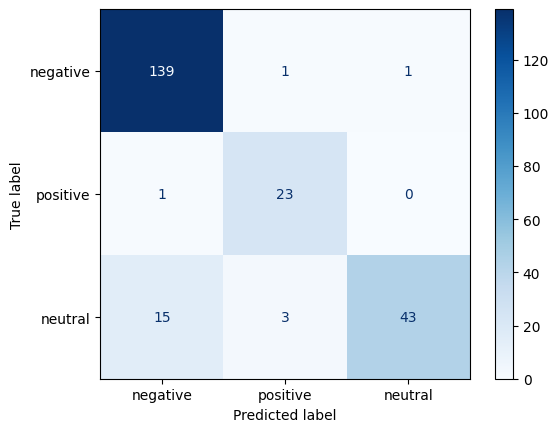

In [ ]:
# Define the label mapping based on your dataset's encoding
label_map = {0: 'positive', 1: 'negative', 2: 'neutral'}

# Convert the numerical true_labels to strings
true_labels_str = [label_map[label] for label in true_labels]

# Now both true_labels_str and predictions are strings and can be compared
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate the metrics using the string labels
accuracy = accuracy_score(true_labels_str, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_str, predictions, average='weighted')

# Print the calculated metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming true_labels_str and predictions are your lists of true and predicted labels respectively
unique_labels = set(true_labels_str + predictions)

# Generate the confusion matrix
cm = confusion_matrix(true_labels_str, predictions, labels=list(unique_labels))

# Create the display object for the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(unique_labels))

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# # prepare groundtruth labels and predictions
# true_labels = [example['label'] for example in dataset['test']]
# # Run the analysis to get predictions
# predictions = run_sentiment_analysis(encoded_dataset['test'])

# # Define the label mapping based on your dataset's encoding
# label_map = {0: 'positive', 1: 'negative', 2: 'neutral'}

# # Convert the numerical true_labels to strings
# true_labels_str = [label_map[label] for label in true_labels]

# # Now both true_labels_str and predictions are strings and can be compared
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# # Calculate the metrics using the string labels
# accuracy = accuracy_score(true_labels_str, predictions)
# precision, recall, f1, _ = precision_recall_fscore_support(true_labels_str, predictions, average='weighted')

# # Print the calculated metrics
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Assuming true_labels_str and predictions are your lists of true and predicted labels respectively
# unique_labels = set(true_labels_str + predictions)

# # Generate the confusion matrix
# cm = confusion_matrix(true_labels_str, predictions, labels=list(unique_labels))

# # Create the display object for the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(unique_labels))

# # Plot the confusion matrix
# disp.plot(cmap=plt.cm.Blues)
# plt.show()

Fine-tune Model

In [ ]:
!pip install transformers[torch]

In [ ]:
from transformers import TrainingArguments, Trainer
import accelerate

# Ensure the labels are integers [0, 1, 2]
def label_function(examples):
    return {'labels': examples['label']}

# Update dataset format for training
encoded_dataset = encoded_dataset.map(label_function)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained('finbert-finetuned')
tokenizer.save_pretrained('finbert-finetuned')

Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,12.451100
20,12.083300
30,8.702000
40,6.937400
50,3.318400
60,2.586400
70,1.286900
80,1.095400
90,0.710600
100,0.717700


('finbert-finetuned/tokenizer_config.json',
 'finbert-finetuned/special_tokens_map.json',
 'finbert-finetuned/vocab.txt',
 'finbert-finetuned/added_tokens.json',
 'finbert-finetuned/tokenizer.json')

In [ ]:
# import os
# os.kill(os.getpid(), 9)

Evaluate Fine-tuned Model

In [ ]:
# Evaluate the model
trainer.evaluate()

# You can access the results with the following:
results = trainer.predict(encoded_dataset['validation'])

Accuracy: 0.9646
Precision: 0.9665
Recall: 0.9646
F1-Score: 0.9642


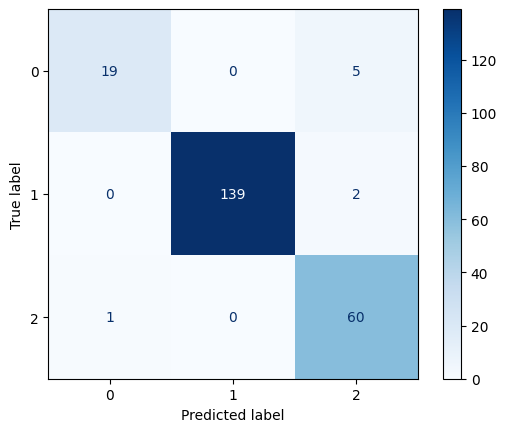

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Obtain the predictions and true labels
preds = np.argmax(results.predictions, axis=-1)
true_labels = results.label_ids

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Confusion matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()

Evaluate on Test set

Test Accuracy: 0.9295
Test Precision: 0.9329
Test Recall: 0.9295
Test F1-Score: 0.9267


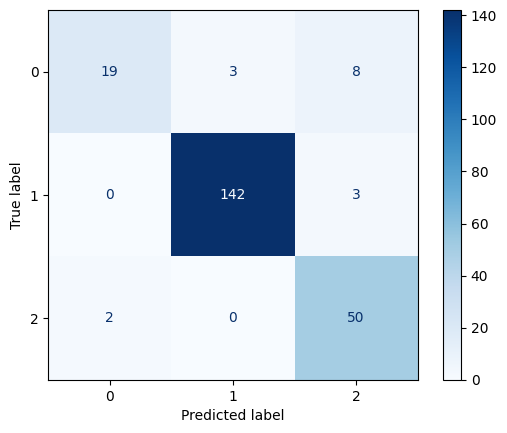

In [ ]:
# Assuming 'test' split is available in your dataset
test_results = trainer.predict(encoded_dataset['test'])

# Obtain the predictions and true labels for the test set
test_preds = np.argmax(test_results.predictions, axis=-1)
test_true_labels = test_results.label_ids

# Calculate evaluation metrics for the test set
test_accuracy = accuracy_score(test_true_labels, test_preds)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_true_labels, test_preds, average='weighted')

# Print the metrics for the test set
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

# Confusion matrix for the test set
test_cm = confusion_matrix(test_true_labels, test_preds)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)

# Plot confusion matrix for the test set
test_disp.plot(cmap=plt.cm.Blues)
plt.show()


Evaluation: improved validation accuracy from 90.7% to 96.5%, with a test accuracy of 93%.